<a href="https://colab.research.google.com/github/9M3a1h3d9i9/Drowsiness_DL_Project/blob/main/Drowsiness_DL_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**In the name of Allah**

Deep Learning Final Project 1404


Mohammad Mahdi Shafighi

In [ ]:
!pip uninstall -y protobuf
!pip install protobuf==4.25.3

Found existing installation: protobuf 6.33.5
Uninstalling protobuf-6.33.5:
  Successfully uninstalled protobuf-6.33.5
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 10.8 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
opentelemetry-proto 1.37.0 requires protobuf<7.0,>=5.0, but you have protobuf 4.25.3 which is incompatible.
grain 0.2.15 requires protobuf>=5.28.3, but you have protobuf 4.25.3 which is incompatible.
ydf 0.14.0 requires protobuf<7.0.0,>=5.29.1, but you have protobuf 4.25.3 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 4.25.3 which is incompatible.


In [ ]:
import os
import json

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
import os

# Downlaod Datasets from Kaggle

In [ ]:
# Kaggle Configuration
kaggle_creds = {
    "username": "Mahdi_Token",
    "key": "KGAT_93e1073195de712e5b436bbc533e0939"
}

# Setup API Token
# ساخت پوشه و فایل کانفیگ به صورت دستی برای دور زدن مشکلات احراز هویت
os.makedirs('/root/.kaggle', exist_ok=True)
with open('/root/.kaggle/kaggle.json', 'w') as f:
    json.dump(kaggle_creds, f)

# تنظیم دسترسی امنیتی (Required by Kaggle)
os.chmod('/root/.kaggle/kaggle.json', 600)

# Fix Colab's Kaggle lib conflict (Common issue in 2024 envs)
!pip install -q --force-reinstall kaggle

# Download & Unzip
dataset_name = "dheerajperumandla/drowsiness-dataset"
zip_name = "drowsiness-dataset.zip"

if not os.path.exists(zip_name):
    print(f"Downloading {dataset_name}...")
    !kaggle datasets download -d {dataset_name}
    !unzip -q {zip_name}
    print("Dataset extracted successfully.")
else:
    print("Dataset already downloaded.")

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires requests==2.32.4, but you have requests 2.32.5 which is incompatible.
tensorflow 2.19.0 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.3, but you have protobuf 6.33.5 which is incompatible.
grpcio-status 1.71.2 requires protobuf<6.0dev,>=5.26.1, but you have protobuf 6.33.5 which is incompatible.
google-ai-generativelanguage 0.6.15 requires protobuf!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<6.0.0dev,>=3.20.2, but you have protobuf 6.33.5 which is incompatible.
Dataset already downloaded.


# Data and Preprocess

## 1. Configuration & Hyperparameters


In [ ]:
IMG_HEIGHT, IMG_WIDTH = 128, 128  # Image dimensions
BATCH_SIZE = 32
EPOCHS = 20
DATA_DIR = './train'
CLASSES = ['Closed', 'Open']      # Explicitly selecting only eye states

## 2. Data Pipeline (Preprocessing)


In [ ]:
# Rescaling and splitting data
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    rotation_range=10,            # Light augmentation
    zoom_range=0.1
)

print("Loading Training Data...")
train_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,              # Only load 'Open' and 'Closed' folders
    subset='training',
    shuffle=True
)

print("Loading Validation Data...")
val_gen = datagen.flow_from_directory(
    DATA_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_mode='binary',
    classes=CLASSES,
    subset='validation'
)


Loading Training Data...
Found 1162 images belonging to 2 classes.
Loading Validation Data...
Found 290 images belonging to 2 classes.


# Model Architecture (CNN)


In [ ]:
def build_model():
    model = Sequential([
        Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3)),

        # Feature Extraction
        Conv2D(32, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D(2, 2),

        # Classification Head
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),             # Regularization
        Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_model()
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 126, 126, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 61, 61, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 28, 28, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 14, 14, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │     3,211,392 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,304,769 (12.61 MB)

 Trainable params: 3,304,769 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training with Callbacks


## Define callbacks for professional training control


In [ ]:
callbacks = [
    EarlyStopping(patience=3, monitor='val_loss', restore_best_weights=True),
    ModelCheckpoint('best_drowsiness_model.h5', save_best_only=True)
]

print("\nStarting Training...")
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=EPOCHS,
    callbacks=callbacks
)


Starting Training...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step - accuracy: 0.7002 - loss: 0.5661

37/37 ━━━━━━━━━━━━━━━━━━━━ 16s 312ms/step - accuracy: 0.7030 - loss: 0.5623 - val_accuracy: 0.8655 - val_loss: 0.3138
Epoch 2/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step - accuracy: 0.9442 - loss: 0.1613

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 209ms/step - accuracy: 0.9442 - loss: 0.1615 - val_accuracy: 0.8862 - val_loss: 0.2565
Epoch 3/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 185ms/step - accuracy: 0.9439 - loss: 0.1317 - val_accuracy: 0.8759 - val_loss: 0.3887
Epoch 4/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 172ms/step - accuracy: 0.9513 - loss: 0.1229

37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 214ms/step - accuracy: 0.9513 - loss: 0.1227 - val_accuracy: 0.9069 - val_loss: 0.2175
Epoch 5/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 219ms/step - accuracy: 0.9742 - loss: 0.0995 - val_accuracy: 0.9069 - val_loss: 0.2653
Epoch 6/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 151ms/step - accuracy: 0.9571 - loss: 0.1150

37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 193ms/step - accuracy: 0.9574 - loss: 0.1144 - val_accuracy: 0.9310 - val_loss: 0.1884
Epoch 7/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 206ms/step - accuracy: 0.9648 - loss: 0.1088 - val_accuracy: 0.9207 - val_loss: 0.2451
Epoch 8/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 7s 183ms/step - accuracy: 0.9559 - loss: 0.1058 - val_accuracy: 0.9000 - val_loss: 0.2249
Epoch 9/20
37/37 ━━━━━━━━━━━━━━━━━━━━ 8s 207ms/step - accuracy: 0.9608 - loss: 0.0891 - val_accuracy: 0.9138 - val_loss: 0.2583


# Evaluation & Visualization


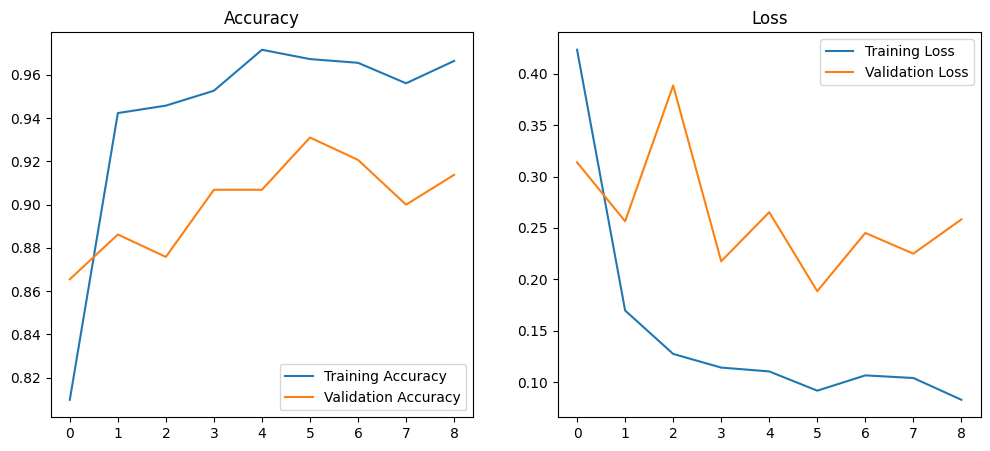

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs_range = range(len(acc))

    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Loss')

    plt.show()

plot_history(history)

# Test

#### این کد را با کمک دستیار های هوش مصنوعی نوشته ام.

لطفاً یک عکس از نمای نزدیک چشم آپلود کنید:


Saving Test_image_1.JPG to Test_image_1 (1).JPG
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 546ms/step


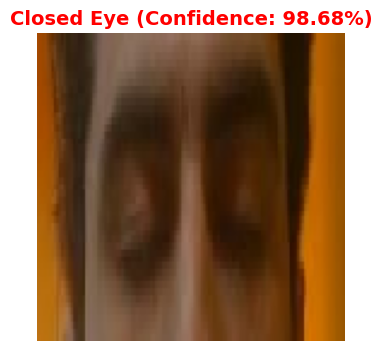

In [ ]:
import numpy as np
from google.colab import files
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt

# بارگذاری بهترین مدل ذخیره شده
model.load_weights('best_drowsiness_model.h5')

def predict_custom_image(path):
    # آماده‌سازی تصویر برای مدل
    img = image.load_img(path, target_size=(128, 128))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = x / 255.0  # نرمال‌سازی

    # پیش‌بینی
    prediction = model.predict(x)
    probability = prediction[0][0]

    # نمایش تصویر و نتیجه
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.axis('off')

    # تفسیر خروجی (با توجه به ترتیب الفبایی: 0=Closed, 1=Open)
    if probability > 0.5:
        label = f"Open Eye (Confidence: {probability:.2%})"
        color = 'green'
    else:
        label = f"Closed Eye (Confidence: {1-probability:.2%})"
        color = 'red'

    plt.title(label, color=color, fontsize=14, fontweight='bold')
    plt.show()

# اجرای تست
print("لطفاً یک عکس از نمای نزدیک چشم آپلود کنید:")
uploaded = files.upload()

for fn in uploaded.keys():
    predict_custom_image(fn)

✅ مدل با موفقیت بارگذاری شد.
لطفاً عکس کامل صورت خود را آپلود کنید:


Saving WIN_20250601_08_21_12_Pro.jpg to WIN_20250601_08_21_12_Pro (2).jpg
تعداد 1 صورت تشخیص داده شد.


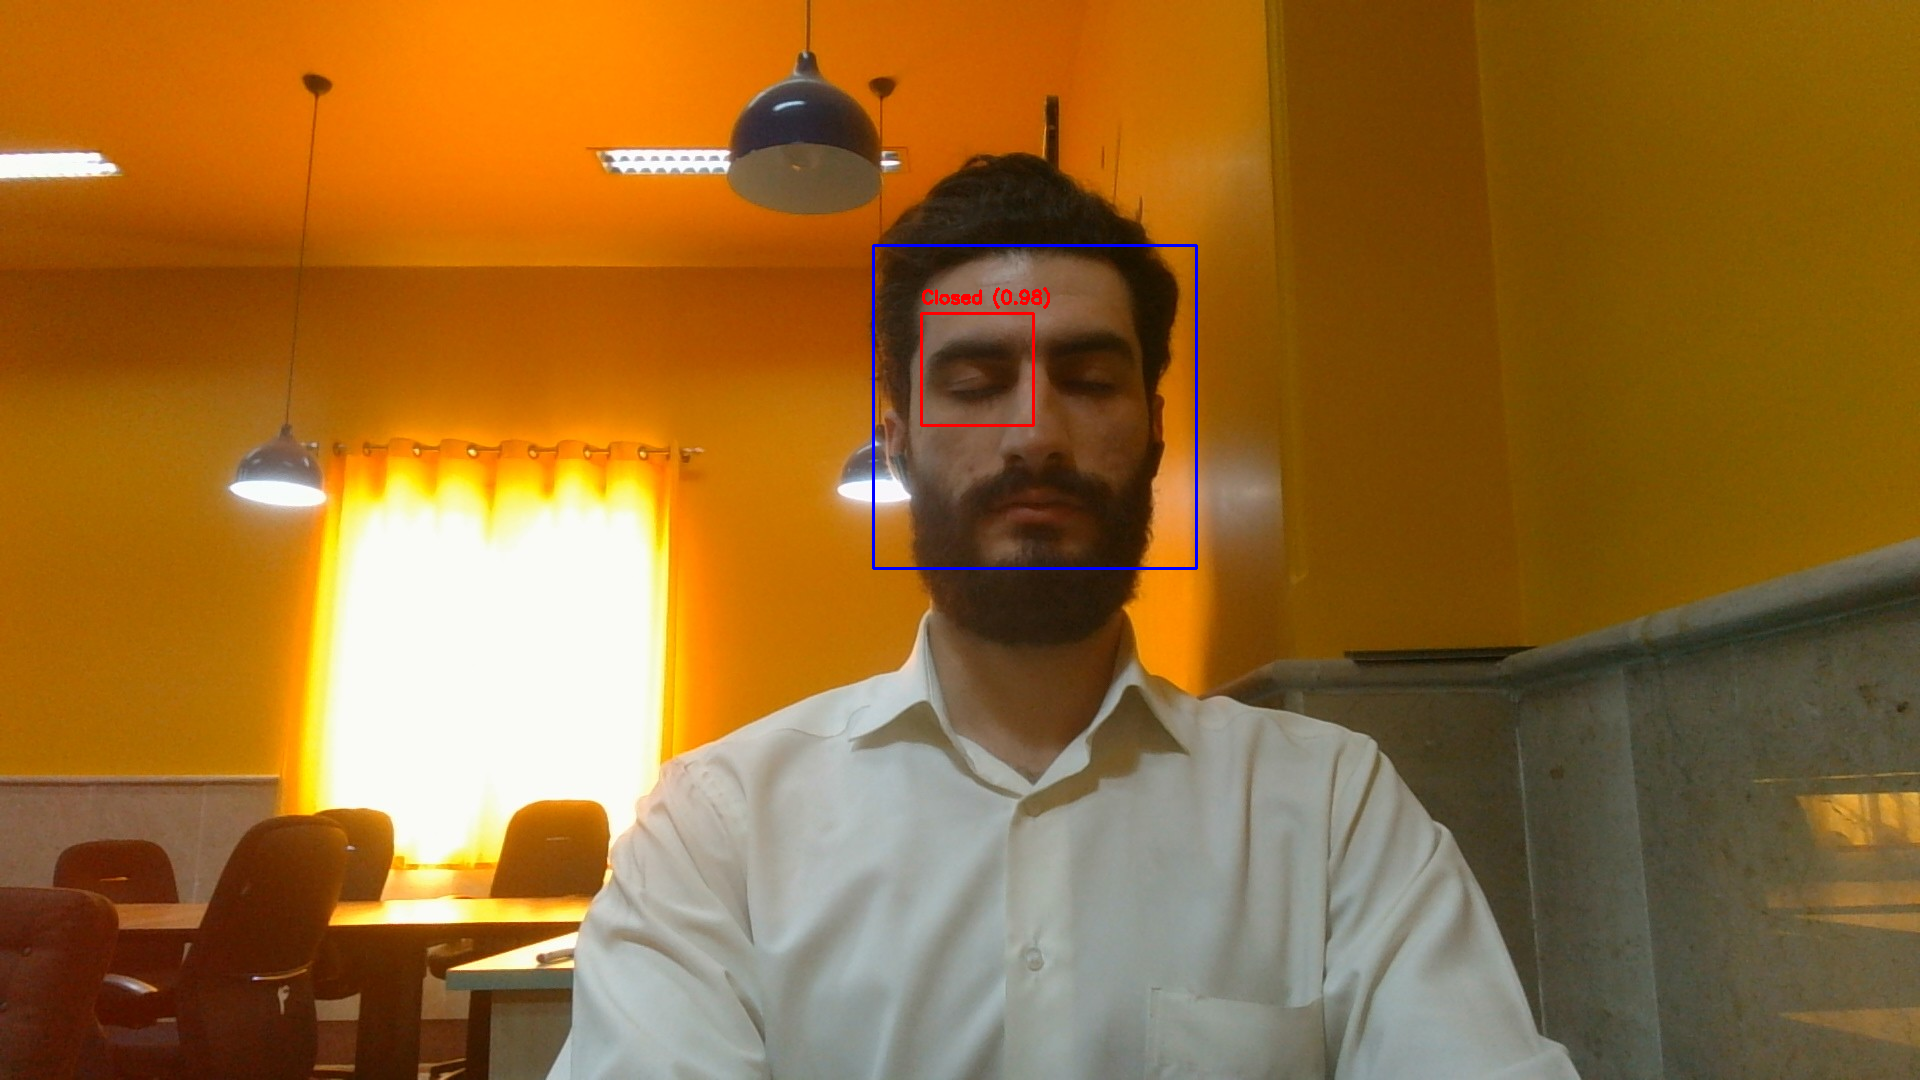

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
import os

# 1. دانلود ابزارهای تشخیص چهره و چشم (اگر قبلاً دانلود نشده باشند)
if not os.path.exists('haarcascade_frontalface_default.xml'):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_frontalface_default.xml
if not os.path.exists('haarcascade_eye.xml'):
    !wget -q https://raw.githubusercontent.com/opencv/opencv/master/data/haarcascades/haarcascade_eye.xml

# 2. بارگذاری مدل‌ها
face_cascade = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')

# بارگذاری مدل آموزش دیده خودمان
try:
    model = load_model('best_drowsiness_model.h5')
    print("✅ مدل با موفقیت بارگذاری شد.")
except:
    print("❌ خطا: فایل مدل پیدا نشد. مطمئن شوید best_drowsiness_model.h5 موجود است.")

# 3. تابع هوشمند تشخیص
def smart_predict_system(image_path):
    img = cv2.imread(image_path)
    if img is None:
        print("تصویر خوانده نشد!")
        return

    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    if len(faces) == 0:
        print("⚠️ هیچ صورتی پیدا نشد. لطفاً عکس واضح‌تر یا با نور بهتری آپلود کنید.")
        return

    print(f"تعداد {len(faces)} صورت تشخیص داده شد.")

    for (x, y, w, h) in faces:
        # رسم مستطیل دور صورت
        cv2.rectangle(img, (x, y), (x+w, y+h), (255, 0, 0), 2)

        # منطقه صورت (ROI)
        roi_gray = gray[y:y+h, x:x+w]
        roi_color = img[y:y+h, x:x+w]

        # تشخیص چشم‌ها
        eyes = eye_cascade.detectMultiScale(roi_gray, 1.1, 4)

        if len(eyes) == 0:
            print("چشمی در صورت پیدا نشد (شاید بسته باشد یا عینک داشته باشید).")

        for (ex, ey, ew, eh) in eyes:
            # برش چشم برای ارسال به مدل
            eye_input = roi_color[ey:ey+eh, ex:ex+ew]

            # پیش‌پردازش دقیقاً مثل زمان آموزش
            final_eye = cv2.resize(eye_input, (128, 128))
            final_eye = np.expand_dims(final_eye, axis=0)
            final_eye = final_eye / 255.0

            # پیش‌بینی مدل
            prediction = model.predict(final_eye, verbose=0)
            prob = prediction[0][0]

            # نمایش نتیجه
            if prob > 0.5:
                status = f"Open ({prob:.2f})"
                color = (0, 255, 0) # سبز
            else:
                status = f"Closed ({1-prob:.2f})"
                color = (0, 0, 255) # قرمز

            # کشیدن کادر و متن
            cv2.rectangle(roi_color, (ex, ey), (ex+ew, ey+eh), color, 2)
            cv2.putText(roi_color, status, (ex, ey-10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, color, 2)

    # نمایش خروجی نهایی
    cv2_imshow(img)

# 4. اجرای سیستم روی عکس آپلودی شما
from google.colab import files
print("لطفاً عکس کامل صورت خود را آپلود کنید:")
uploaded = files.upload()

for fn in uploaded.keys():
    smart_predict_system(fn)